In [5]:
import torch
print("PyTorch çalışıyor mu? ->", torch.__version__)
cpu = torch.rand(3,3)
print(cpu)


PyTorch çalışıyor mu? -> 2.6.0
tensor([[0.7376, 0.4303, 0.4639],
        [0.3291, 0.4667, 0.8299],
        [0.5647, 0.7687, 0.3360]])


In [6]:
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn

# ---- Veri seti klasörlerinin hazırlanması ----
DATA_DIR = "../data/SKU110K_fixed"
IMG_DIR = os.path.join(DATA_DIR, "images")
ANN_DIR = os.path.join(DATA_DIR, "annotations")

train_csv_path = os.path.join(ANN_DIR, "annotations_train.csv")
print("CSV yolu:", train_csv_path)

# ---- Etiket dosyasını yükle (bu CSV’de sütun isimleri olmadığı için header=None) ----
df = pd.read_csv(train_csv_path, header=None)
print("Toplam annotation satırı:", len(df))
print(df.head())


CSV yolu: ../data/SKU110K_fixed\annotations\annotations_train.csv
Toplam annotation satırı: 1208482
             0     1     2     3     4       5     6     7
0  train_0.jpg   208   537   422   814  object  3024  3024
1  train_0.jpg  1268  1923  1365  2209  object  3024  3024
2  train_0.jpg  1135  2074  1261  2166  object  3024  3024
3  train_0.jpg  1045  2085  1122  2258  object  3024  3024
4  train_0.jpg   976  2036  1040  2177  object  3024  3024


In [7]:
# CSV sütunlarının anlamı:
# 0: image_name, 1:x1, 2:y1, 3:x2, 4:y2, 5:class, 6:width, 7:height

# ---- Aynı görüntüye ait satırları bir araya topla ----
grouped = df.groupby(0)

samples = []
for img_name, g in grouped:
     # Her görüntüden sadece ilk bounding box'ı alıyoruz
    row = g.iloc[0]  
    x1, y1, x2, y2 = row[1], row[2], row[3], row[4]
    img_w, img_h = row[6], row[7]
     # Eğitimde kullanacağımız sade bir örnek listesi oluştur
    samples.append((img_name, x1, y1, x2, y2, img_w, img_h))

print("Toplam görüntü (sample):", len(samples))
print("İlk örnek:", samples[0])

# Eğitimi hızlandırmak için bir kısmını kullandım
samples_small = samples[:2000]
print("Kullanılacak örnek sayısı:", len(samples_small))


Toplam görüntü (sample): 8219
İlk örnek: ('train_0.jpg', np.int64(208), np.int64(537), np.int64(422), np.int64(814), np.int64(3024), np.int64(3024))
Kullanılacak örnek sayısı: 2000


In [8]:
IMG_SIZE = 256

class ShelfSingleBoxDataset(Dataset):
    def __init__(self, samples, img_dir, img_size=256):
        self.samples = samples
        self.img_dir = img_dir
        self.img_size = img_size

    def __len__(self):
        # Kaç adet görüntü örneği olduğunu döndürüyoruz
        return len(self.samples)

    def __getitem__(self, idx):
         # Seçilen örneğe ait bilgileri al
        img_name, x1, y1, x2, y2, img_w, img_h = self.samples[idx]
        img_path = os.path.join(self.img_dir, img_name)

         # Görüntüyü okuyup sabit boyuta getir
        img = Image.open(img_path).convert("RGB")
        img = img.resize((self.img_size, self.img_size))

         # Görüntüyü tensöre dönüştür (0-1 aralığına ölçekle)
        img_np = np.array(img, dtype=np.float32) / 255.0
        img_tensor = torch.from_numpy(img_np).permute(2, 0, 1)

       # Bounding box değerlerini orijinal boyuta göre normalize et
        x1_n = x1 / img_w
        y1_n = y1 / img_h
        x2_n = x2 / img_w
        y2_n = y2 / img_h

        target = torch.tensor([x1_n, y1_n, x2_n, y2_n], dtype=torch.float32)

        return img_tensor, target
# Dataset’i oluştur
dataset = ShelfSingleBoxDataset(samples_small, IMG_DIR, IMG_SIZE)
print("Dataset uzunluğu:", len(dataset))

# Örnek bir veri çekelim
sample_img, sample_target = dataset[0]
print("Tek örnek image shape:", sample_img.shape)
print("Tek örnek target:", sample_target)


Dataset uzunluğu: 2000
Tek örnek image shape: torch.Size([3, 256, 256])
Tek örnek target: tensor([0.0688, 0.1776, 0.1396, 0.2692])


In [9]:
BATCH_SIZE = 8
# DataLoader: veriyi mini-batch’ler halinde yükleyip karıştırarak hazırlar
train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
# Bir batch örneği alıp şekillerine bakalım
batch_imgs, batch_targets = next(iter(train_loader))
print("batch_imgs shape:", batch_imgs.shape)       # Görüntü tensörlerinin boyutu
print("batch_targets shape:", batch_targets.shape)   # Normalize edilmiş kutu koordinatları


batch_imgs shape: torch.Size([8, 3, 256, 256])
batch_targets shape: torch.Size([8, 4])


In [10]:
class TinyShelfNet(nn.Module):
    def __init__(self):
        super(TinyShelfNet, self).__init__()
        
         # Görüntüden özellik çıkartan katmanlar (her blokta conv → aktivasyon → pool)
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),    # Çıktı boyutu: 128x128

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),   # 64x64

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),   # 32x32

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),   # 16x16
        )

        # Bounding box regresyon katmanları
        self.regressor = nn.Sequential(
            nn.Flatten(),    # Özellikleri tek boyuta indir
            nn.Linear(256 * 16 * 16, 256),   # Tam bağlı katman
            nn.ReLU(),
            nn.Linear(256, 4),   # 4 çıktı: x1, y1, x2, y2
            nn.Sigmoid()     # Çıktıları 0-1 aralığında tut
        )

    def forward(self, x):
        x = self.features(x)    # Görüntüden özellik çıkar
        x = self.regressor(x)    # Kutuyu tahmin et
        return x
# Modeli oluşturup yapısını ekrana yazdır
model = TinyShelfNet()
print(model)


TinyShelfNet(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (regressor): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=65536, out_features=256, bias=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=4, bias=True)
    (4): Sigmoid()
  )
)


In [11]:
# Eğitimde hangi donanımı kullanacağımıza karar ver (GPU varsa onu seç)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Kullanılan cihaz:", device)

# Modeli yeniden başlat (sıfırdan eğitim)
model = TinyShelfNet().to(device)
# Hedef kutu ile tahmin arasındaki farkı ölçmek için MSE kaybı
criterion = nn.MSELoss()
# Parametreleri güncellemek için optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

EPOCHS = 3  
loss_history = []

for epoch in range(EPOCHS):
    model.train()    # Modeli eğitim moduna al
    running_loss = 0.0

    for imgs, targets in train_loader:
        # Veri ve etiketleri cihaza gönder
        imgs = imgs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()  # Önceki gradient’leri temizle
        outputs = model(imgs)  # Modelin tahminini al
        loss = criterion(outputs, targets)  # Kayıp hesapla
        loss.backward()    # Geri yayılım
        optimizer.step()    # Ağırlıkları güncelle


        running_loss += loss.item() * imgs.size(0)
        loss_history.append(loss.item())
        
    # Epoch başına ortalama kaybı yazdır
    epoch_loss = running_loss / len(dataset)
    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {epoch_loss:.4f}")


Kullanılan cihaz: cpu
Epoch 1/3 - Loss: 0.0658
Epoch 2/3 - Loss: 0.0651
Epoch 3/3 - Loss: 0.0650


In [12]:
# Eğitimi tamamlanan modelin ağırlıklarını dosyaya kaydet
MODEL_PATH = "tinyshelfnet_base.pth"
torch.save(model.state_dict(), MODEL_PATH)
print("Model kaydedildi:", MODEL_PATH)


Model kaydedildi: tinyshelfnet_base.pth


In [13]:
import numpy as np

# İki kutu arasındaki IoU değerini hesaplayan fonksiyon
def iou(box1, box2):
    # Kesişim (intersection) bölgesinin koordinatlarını bul
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
     # Kesişim genişliği ve yüksekliği (negatif olmaması için max(0))
    inter_w = max(0.0, x2 - x1)
    inter_h = max(0.0, y2 - y1)
    inter = inter_w * inter_h
      # Her kutunun alanı
    area1 = max(0.0, box1[2] - box1[0]) * max(0.0, box1[3] - box1[1])
    area2 = max(0.0, box2[2] - box2[0]) * max(0.0, box2[3] - box2[1])
    # Birleşim alanı: alan1 + alan2 - kesişim
    union = area1 + area2 - inter + 1e-6  # sıfıra bölme hatasını önlemek için küçük sabit
    return inter / union
    
# Modeli değerlendirme moduna al
model.eval()
ious = []

# Tahmin-GT karşılaştırmaları için birkaç batch üzerinden IoU hesapla
with torch.no_grad():
    for i, (imgs, targets) in enumerate(train_loader):
        imgs = imgs.to(device)
        
        preds = model(imgs).cpu().numpy() # Model tahminleri
        gts = targets.cpu().numpy()  # Gerçek kutular

          # Her görüntü için IoU ekle
        for gt, pr in zip(gts, preds):
            ious.append(iou(gt, pr))

        if i >= 9:  # sadece ilk 10 batch
            break

print("Örneklerde Ortalama IoU:", float(np.mean(ious)))


Örneklerde Ortalama IoU: 0.00012241896183695644


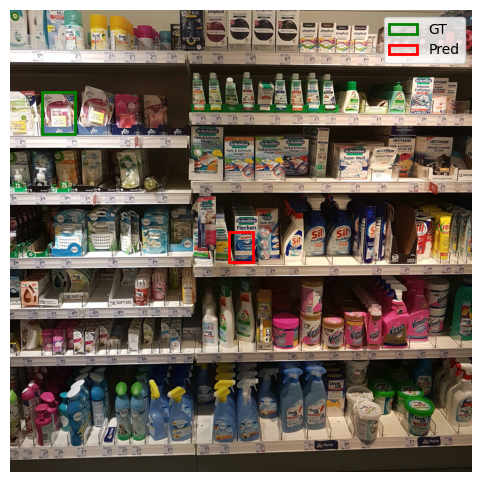

In [14]:
import matplotlib.patches as patches

# İlk örneğe ait görüntü ve kutu bilgilerini al
img_name, x1, y1, x2, y2, img_w, img_h = samples_small[0]
img_path = os.path.join(IMG_DIR, img_name)

# Gerçek kutuyu (GT) normalize edilmiş hale getir (0-1 aralığı)
gt_box_norm = np.array([x1/img_w, y1/img_h, x2/img_w, y2/img_h], dtype=np.float32)

# Modele girecek şekilde görüntüyü hazırla
img = Image.open(img_path).convert("RGB")
img_resized = img.resize((IMG_SIZE, IMG_SIZE))
img_np = np.array(img_resized, dtype=np.float32) / 255.0
img_tensor = torch.from_numpy(img_np).permute(2,0,1).unsqueeze(0).to(device)

# Modelden tahmin al (kutu normalize edilmiş halde gelir)
model.eval()
with torch.no_grad():
    pred_box_norm = model(img_tensor)[0].cpu().numpy()
    
# Normalize kutuyu orijinal boyuta geri döndür
def denorm(box, w, h):
    return box[0]*w, box[1]*h, box[2]*w, box[3]*h

# Orijinal boyutta çizelim
w, h = img.size
# GT ve tahmin kutularını eski koordinatlarına çevir
gt_x1, gt_y1, gt_x2, gt_y2 = denorm(gt_box_norm, w, h)
pr_x1, pr_y1, pr_x2, pr_y2 = denorm(pred_box_norm, w, h)

# Görüntü üzerine kutuları çiz
fig, ax = plt.subplots(1,1, figsize=(6,6))
ax.imshow(img)

# Gerçek kutu (yeşil)
ax.add_patch(patches.Rectangle((gt_x1, gt_y1), gt_x2-gt_x1, gt_y2-gt_y1,
                               linewidth=2, edgecolor='g', facecolor='none', label="GT"))

# Tahmin kutusu (kırmızı)
ax.add_patch(patches.Rectangle((pr_x1, pr_y1), pr_x2-pr_x1, pr_y2-pr_y1,
                               linewidth=2, edgecolor='r', facecolor='none', label="Pred"))

ax.legend()
plt.axis("off")
plt.show()
